In [21]:
import numpy as np
from collections import UserList, UserDict
import networkx as nx
import heapq as hq
from itertools import combinations
from matplotlib import patches
from scipy.spatial import ConvexHull, Delaunay
import numpy as np
from itertools import chain
import matplotlib
import pickle
import heapq as hq
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import cKDTree
import time
%matplotlib inline
# %matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (16, 6)

In [22]:
def euclidean_dist(x1, x2):
    return numpy.linalg.norm(np.array(x1) - np.array(x2))

def mapl(f, *seq):
    return list(map(f, *seq))


def timed(f):
    """Wrapper that returns a timed version of function."""

    def wrapper(*args, **kwargs):
        start = time.time()
        ret = f(*args, **kwargs)
        end = time.time()

        return ret, (end - start)

    return wrapper


def sample_edge(v1, v2, num_samples=20, theta=None):
        sample_points = []
        x1, y1 = v1
        x2, y2 = v2
        if np.isclose((x2 - x1), 0):
            x = [x1] * num_samples
            y = np.arange(y1, y2, (y2 - y1) / num_samples)
        else:
            m = (y2 - y1) / (x2 - x1)
            c = y1 - (m * x1)

            x = np.arange(x1, x2, (x2 - x1) / num_samples)
            y = m * x + c
        if theta is not None:
            thetas = [theta] * num_samples
            for p in zip(x, y, thetas):
                sample_points.append(p)
        else:
            for p in zip(x, y):
                sample_points.append(p)
        return sample_points


def nearest5(x):
    return round(x / 5) * 5


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


ADJ_S = {0: (1, 0), 5: (11, 1), 10: (6, 1), 15: (4, 1), 20: (3, 1), 25: (2, 1), 30: (9, 5), 35: (3, 2), 40: (6, 5), 45: (1, 1),
         50: (5, 6), 55: (2, 3), 60: (5, 9), 65: (1, 2), 70: (1, 3), 75: (1, 4), 80: (1, 6), 85: (1, 11), 90: (0, 1)}
def adjacent_square(x, y, theta):
    ax, ay = ADJ_S[theta]
    return x + ax, y + ay

In [23]:
class Polygon(object):
    """Polygons to describe the car and obstacles in the environment.
    
    Attributes:
        vertices: Coordinates of the vertices of the polygon.
    """
    def __init__(self, vertices):
        self.vertices = np.array(vertices)  # n x 2 matrix
        self.angular_sort_vertices()
        self.hull = None
    
    def __contains__(self, point):
        """Check if point in interior of the polygon.
        Credits: https://stackoverflow.com/questions/16750618/whats-an-efficient-way-to-find-if-a-point-lies-in-the-convex-hull-of-a-point-cl
        """
        if self.hull is None:
            self.hull = Delaunay(self.vertices)
        return self.hull.find_simplex(point) >= 0

    def __add__(self, polygon2):
        """Returns a 'sum polygon' of the the two polygons.
        This 'sum polygon' is formed by the convex hull of the Minkowski sum
        of a ReferenceRectange and a Polygon.
        """
        # TODO: With a reference center (should be possible with a simple center subtracation)
        r_verts = self.rotated_vertices(180)
        new_vertices = []
        for v1 in r_verts:
            for v2 in polygon2.vertices:
                new_vertices.append(v1 + v2)
        hull = ConvexHull(new_vertices)

        return Polygon(hull.points[hull.vertices])
    
    def get_dense_edges(self, num_samples=20, theta=None):
        """Returns a large number of points per edge."""
        self.angular_sort_vertices()
        edge_points = []
        for i in range(len(self.vertices) - 1):
            v1, v2 = self.vertices[i], self.vertices[i + 1]
            edge_points.extend(sample_edge(v1, v2, num_samples, theta))
        v1, v2 = self.vertices[-1], self.vertices[0]
        edge_points.extend(sample_edge(v1, v2, num_samples, theta)) 
        
        return edge_points

    def angular_sort_vertices(self):
        centroid = np.mean(self.vertices, axis=0)
        centered_vertices = self.vertices - centroid
        angles = [np.arctan2(v[1], v[0]) for v in centered_vertices]

        temp = list(sorted(enumerate(self.vertices), key=lambda t: angles[t[0]]))
        sorted_vertices = np.array(mapl(lambda tupl: tupl[1], temp))
        self.vertices = sorted_vertices

    def rotated_vertices(self, rot):
        theta = np.deg2rad(rot)
        centroid = np.mean(self.vertices, axis=0)
        centered_vertices = self.vertices - centroid

        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        vertices = np.matmul(R, centered_vertices.T).T
        vertices += centroid
        return vertices

    def to_patches_polygon(self):
        """Return a corresponding patches.Polygon instance."""
        self.angular_sort_vertices()
        return patches.Polygon(self.vertices)

        
class Rectangle(Polygon):
    """Rectangle to describe different elements of the environment.
    Attributes:
        lxy: Coordinates of the lower-left vertex.
        w: Width.
        h: Height.
    """
    def __init__(self, lxy, w, h):
        self.lxy = lxy
        self.w = w
        self.h = h
        vertices = []
        for x in (0, w):
            for y in (0, h):
                vertices.append([lxy[0] + x, lxy[1] + y])
        super().__init__(vertices)


class ReferenceRectangle(Rectangle):
    """Rectange with a reference frame.
    
    Attributes:
        cxy: Coordinates of the origin of reference frame w.r.t. lxy of the
           rectangle.
        w: Width.
        h: Height.
        rot: Rotation, in degrees, counter-clockwise w.r.t. x-axis.
    """
    def __init__(self, cxy, w, h, rot=None):
        lxy = [-cxy[0], -cxy[1]]
        super().__init__(lxy, w, h)
        if rot is not None:
            theta = np.deg2rad(rot)
            R = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
            # n = self.vertices.shape[0]
            self.vertices = np.matmul(R, self.vertices.T).T
        else:
            rot = 0


class Environment(UserList):
    """Collection of all the polygons in the environment.
    
    Attributes:
        polygons: list of polygons.
    """
    def __init__(self, polygons=None):
        if polygons is None:
            polygons = []
        self.data = polygons
    
    def in_obstacle(self, point):
        """Checks if point is in the interior of an obstacle."""
        for obstacle in self.data:
            if point in obstacle:
                return True
        return False



def make_graph(cspace):
    INTV = 5  # interval
    graph = nx.Graph()
    for x in range(1, 801):
        if x % 20 == 0:
            print(x)
            print(graph.number_of_edges())
            print(graph.number_of_nodes())
        for y in range(1, 301):
            for theta in range(0, 91, INTV):
                if theta != 90:
                    check_add_edge(graph, (x, y, theta), (x, y, theta + INTV), 
                                   cspace, 0)
                add_adjacent_square(x, y, theta, graph, cspace)
                
    return graph


def check_add_edge(graph, p1, p2, cspace, w=None):
    x1, y1, theta1 = p1
    x2, y2, theta2 = p2
    if cspace[theta1].in_obstacle((x1, y1)) or cspace[theta2].in_obstacle((x2, y2)):
        return False
    if w is None:
        w = LA.norm((x1 - x2, y1 - y2))
    graph.add_edge(p1, p2, weight=w)
    return True


def add_adjacent_square(x, y, theta, graph, cspace):
    env = cspace[theta]
    x2, y2 = adjacent_square(x, y, theta)
    if check_edge_intersect((x, y, theta), (x2, y2, theta), env):
        check_add_edge(graph, (x, y, theta), (x2, y2, theta), cspace)
    

def check_edge_intersect(p1, p2, env):
    """Checks if the edge between p1 and p2 intersects an obstacle."""
    x1, y1, *_ = p1
    x2, y2, *_ = p2
    num_samples = int(LA.norm((x1 - x2, y1 - y2)))
    if num_samples == 0: 
        return True
    samples = sample_edge((x1, y1), (x2, y2), num_samples)
    is_intersect = any(map(env.in_obstacle, samples))
    return not is_intersect



class Graph(UserDict):
    """Graph data structure with helper methods."""
    def __init__(self, graph=None):
        if graph is not None:
            self.data = graph
        else:
            self.data = {}
        # Vertex set
        self.vset = set()
    
    def add_edge(self, p1, p2, w):
        t1, t2 = tuple(p1), tuple(p2)
        try:
            self.data[t1][t2] = w
        except KeyError:
            self.data[t1] = {t2: w}
    
    def populate_vset(self, cspace, thetas):
        for i, plane in enumerate(cspace):
            theta = thetas[i]
            for vertex in plane:
                self.vset.add((vertex[0], vertex[1], theta))
    
    def all_vertices(self):
        if not self.vset:
            self.vset = set()
            for key in self.data:
                self.vset.add(key)
                for inner_key in self.data[key]:
                    self.vset.add(inner_key)
        return self.vset

In [24]:
def mapl(f, *seq):
    return list(map(f, *seq))

def random_point(xmin=0, xmax=801, ymin=0, ymax=301, tint=5):
    rx = np.random.randint(xmin, xmax)
    ry = np.random.randint(ymin, ymax)
    rtheta = np.random.choice(list(range(0, 91, tint)))
    
    return (rx, ry, rtheta)

def plot_polygons(env, path=None, scatter_points=None):
    # This very is similar to
    # https://stackoverflow.com/questions/26935701/ploting-filled-polygons-in-python
    fig, ax = plt.subplots()
    patches = mapl(lambda poly: poly.to_patches_polygon(), env)
    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.9)
    colors = 100*np.random.rand(len(patches))
    p.set_array(np.array(colors))


    major_ticks_x = np.arange(0, 801, 25)
    major_ticks_y = np.arange(0, 301, 25)
    plt.gca().invert_yaxis()
    ax.add_collection(p)
    ax.set_xticks(major_ticks_x)
    ax.set_yticks(major_ticks_y)    
    ax.xaxis.tick_top()
    
    if path is not None:
        plt.plot(path[:, 0], path[:, 1], c='red', label='Shortest Path')
    if scatter_points is not None:
        plt.scatter(scatter_points[:, 0], scatter_points[:, 1], label='Nodes')
    
    if path is not None or scatter_points is not None:
        plt.legend()
    plt.show()

In [25]:
#Configuration space class is defined in config_space.ipynb file

# The parameters of gen_room function are ([x,y], width, height)
# x, y are the co ordinates, width is the width and height is the height of the rectangle.
# Height = 1 or width = 1 for a line
top = Rectangle([0, 0], 800, 1)
bottom = Rectangle([0, 299], 800, 1)
left = Rectangle([0, 0], 1, 300)
right = Rectangle([799, 0], 1, 300)
wall_1 = Rectangle([200, 0], 1, 200)
wall_2 = Rectangle([100, 199], 200, 1)
wall_3 = Rectangle([400, 100], 1, 200)
wall_4 = Rectangle([600, 0], 1, 200)
wall_5 = Rectangle([500, 199], 200, 1)

#Plot the environment
env = Environment([top, bottom, left, right, 
                      wall_1, wall_2, wall_3, wall_4, wall_5])

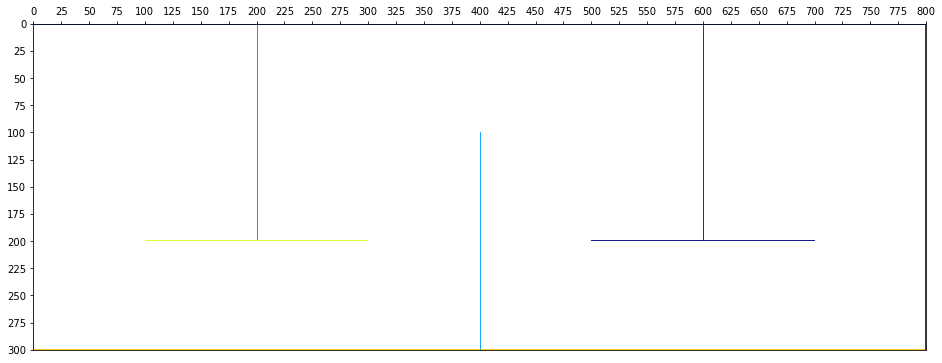

In [26]:
plot_polygons(env)